# Alpha Decay Project
By Nicolas Harvie

See README for project description

In [2]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

***
## Setup

In [3]:
# Predictors from Chen & Zimmerman (2023)
LS = pd.read_csv('../data/chen_predictors_2023.csv')
LS['date'] = pd.to_datetime(LS['date'])
LS = LS.set_index(LS['date'],drop=True)
LS = LS.drop(columns={'date'})

# Get the Same Index as the FF data by changing the time period 
LS.index = LS.reset_index()['date'].dt.to_period('M')

In [4]:
# Visualizing the LS portfolios
LS

,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12
date,,,,,,,,,,,,,,,,,,,,,
1926-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-13.686393,NaN,NaN,NaN,NaN,NaN,NaN
1926-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-5.135248,NaN,NaN,NaN,NaN,NaN,NaN
1926-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-4.832534,NaN,NaN,NaN,NaN,NaN,NaN
1926-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-4.440934,NaN,NaN,NaN,NaN,NaN,NaN
1926-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.483265,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08,1.019538,-2.412224,-1.913597,1.928721,2.741776,NaN,NaN,1.347350,-4.050457,0.510279,...,-1.615839,-11.692944,-8.326179,-4.467901,0.216663,-5.978392,8.577257,-2.591933,-2.451913,-1.467892
2022-09,-2.888651,2.895650,-0.492878,1.546341,-5.482939,NaN,NaN,-6.515619,-2.104168,-0.242502,...,-4.828041,2.106418,2.906625,-3.030688,0.105947,8.239848,0.485810,10.430349,6.948029,4.607782
2022-10,3.384184,-3.041480,-0.437972,1.439492,14.154554,NaN,NaN,-2.241708,5.847384,0.048826,...,-2.659325,13.064743,9.269617,-0.339419,-0.638394,-4.242074,-8.276771,-4.179820,-3.358313,-5.818550


In [5]:
# Signal Documentation from CZ
signal_doc = pd.read_csv('../data/signal_doc.csv')

# Have a DF with all the ending and starting dates for the studies
study_dates = signal_doc[['Acronym', 'SampleStartYear', 'SampleEndYear', 'Year']]
study_dates['Year'] = pd.to_datetime(study_dates['Year'].astype(str)).dt.to_period('M')
study_dates['Start'] = pd.to_datetime(study_dates['SampleStartYear'].astype(str)).dt.to_period('M')
study_dates['End'] = pd.to_datetime(study_dates['SampleEndYear'].astype(str)).dt.to_period('M')
study_dates = study_dates.set_index('Acronym')
study_dates['End'] = study_dates['End'] + 11
study_dates

,SampleStartYear,SampleEndYear,Year,Start,End
Acronym,,,,,
AbnormalAccruals,1971,1992,2001-01,1971-01,1992-12
Accruals,1962,1991,1996-01,1962-01,1991-12
AccrualsBM,1980,1998,2004-01,1980-01,1998-12
Activism1,1990,2001,2005-01,1990-01,2001-12
AM,1963,1990,1992-01,1963-01,1990-12
...,...,...,...,...,...
SP_q,1979,1991,1996-01,1979-01,1991-12
tang_q,1973,2001,2009-01,1973-01,2001-12
Tax_q,1973,2000,2004-01,1973-01,2000-12


***
## Core 

In [6]:
# Preparing the rolling alpha dataframe
rolling_alpha_df = pd.DataFrame(index=LS.index,  columns=LS.columns)

In [7]:
###=== ROLLING ALPHA REGRESSION FOR CZ PREDICTORS ===###
def rolling_alpha_regression(factor):
    """Computes a rolling least square estimation for alpha to determine decay in significance of
    various predictors

    Parameters:
    factor (df): The exceeding returns dataframe of the factors
    """
    factor_df = pd.DataFrame(LS[factor]).dropna()

    # Slicing the DF according to date
    # Corresponds to our "in sample alpha"
    # starting_period = factor.index.min()
    ending_period = factor_df.index.min() + 1 

    while ending_period <= factor_df.index.max():
        
        # New factor with adequate date range index
        new_date_factor = factor_df[(factor_df.index <= ending_period)]
        # Setting the variables 
        Y = new_date_factor.iloc[:,-1]
        
        # Doing the Regression
        reg = smf.ols('Y ~ 1',data=new_date_factor).fit()
        
        # Appending the t_values for our new date range
        rolling_alpha_df.at[ending_period, factor] = reg.tvalues[0]
        
        # Incrementing the ending period 
        ending_period += 1 

In [8]:
# Computing rolling alpha on all our predictors 
# Can be specified to some factors rather than the full sample
# Compute time for full sample: ~ 2min
# for factor in rolling_alpha_df:
#     rolling_alpha_regression(factor)
# rolling_alpha_df.to_csv('../data/rolling_alpha_2023.csv')
rolling_alpha_df = pd.read_csv('../data/rolling_alpha_2023.csv', parse_dates=['date'], index_col='date')

In [9]:
###=== PLOTTING ROLLING SIGNIFICATIVITY FOR FACTORS===### 
def plot_rolling_alpha(factor):

    factor_df = pd.DataFrame(rolling_alpha_df[factor]).dropna()
    #factor_df.index = factor_df.index.to_timestamp()

    
    # Define dates for horizontal lines
    IS = study_dates.at[factor, 'Start']
    OOS =  study_dates.at[factor, 'End']
    publication = study_dates.at[factor, 'Year']

    # Plot time series with horizontal lines
    fig, ax = plt.subplots(figsize=(16,8))
    
    ax.plot(factor_df.index, factor_df.values, label='Alpha')
    
    ax.axvline(IS, linestyle='--', color='r', label='In-Sample Starts')
    ax.axvline(OOS, linestyle='--', color='g', label='Out-of-Sample Starts')
    ax.axvline(publication, linestyle='--', color='b', label='Publication')
    ax.legend(loc='upper left')
    
    ax.set_title(f'Rolling Alpha for {factor}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Alpha')
    ax.legend()
    plt.show()

In [10]:
# To plot all of them (not recommended)
# for factor in LS.columns:
#     plot_rolling_alpha(factor)

***
## Significance by Status 

In [11]:
state_alpha_df = pd.DataFrame(index=LS.columns, columns = ['OOS_Prepublication', 'In-Sample', 'OOS_Postpublication' , 'Total', 'Recent'])

In [12]:
def state_alpha(factor):
    
    factor_df = pd.DataFrame(LS[factor]).dropna()

    IS = study_dates.at[factor, 'Start']
    OOS =  study_dates.at[factor, 'End']
    publication = study_dates.at[factor, 'Year']

    # OUT OF SAMPLE PRE-PUBLICATION
    oos_prepublication = factor_df[(factor_df.index <= IS) | ((factor_df.index > OOS) & (factor_df.index < publication))]
    Y = oos_prepublication.iloc[:,-1]
    reg_oos_prepublication = smf.ols('Y ~ 1',data=Y).fit()
    state_alpha_df.at[factor, 'OOS_Prepublication']  = reg_oos_prepublication.tvalues[0]

    # OUT OF SAMPLE POST-PUBLICATION
    oos_postpublication = factor_df[(factor_df.index >= publication)]
    Z = oos_postpublication.iloc[:,-1]
    reg_oos_postpublication = smf.ols('Z ~ 1',data=Z).fit()
    state_alpha_df.at[factor, 'OOS_Postpublication']  = reg_oos_postpublication.tvalues[0]

    # IN-SAMPLE
    in_sample = factor_df[(factor_df.index >= IS) & (factor_df.index <= OOS)]
    I = in_sample.iloc[:,-1]
    reg_in_sample = smf.ols('I ~ 1',data=I).fit()
    state_alpha_df.at[factor, 'In-Sample']  = reg_in_sample.tvalues[0]

    # TOTAL
    total = factor_df
    T = total.iloc[:,-1]
    reg_total = smf.ols('T ~ 1',data=T).fit()
    state_alpha_df.at[factor, 'Total']  = reg_total.tvalues[0]

    # LAST 10 YEARS
    last = factor_df[factor_df.index >= '2008-01']
    L = last.iloc[:,-1]
    reg_L = smf.ols('L ~ 1',data=L).fit()
    state_alpha_df.at[factor, 'Recent']  = reg_L.tvalues[0]


    


In [13]:
for factor in state_alpha_df.index:
    try:
        state_alpha(factor)
    except:
        continue

In [14]:
state_alpha_df

,OOS_Prepublication,In-Sample,OOS_Postpublication,Total,Recent
AM,0.648332,3.490413,2.169448,3.645117,0.821851
AOP,1.018854,2.081526,0.105321,1.623145,0.385686
AbnormalAccruals,0.2295,4.95321,-0.751309,2.054996,0.00514
Accruals,2.699863,6.703088,1.571424,6.551883,0.399498
AccrualsBM,3.636836,4.858997,3.507211,6.716097,3.151125
...,...,...,...,...,...
std_turn,2.506769,3.413475,-0.092317,2.994868,0.283095
tang,0.264089,3.645626,0.005206,2.581453,-0.154756
zerotrade,2.143264,2.629114,0.606091,3.17043,0.584115
zerotradeAlt1,1.897413,3.795217,0.871612,3.676714,0.801746


In [15]:
state_alpha_df.mean()

OOS_Prepublication     1.757074
In-Sample              3.944982
OOS_Postpublication    1.400385
Total                  4.146932
Recent                  1.14921
dtype: object

In [16]:
state_alpha_df[(state_alpha_df['In-Sample'] >= 3) & (state_alpha_df['OOS_Postpublication'] <= 3)]

,OOS_Prepublication,In-Sample,OOS_Postpublication,Total,Recent
AM,0.648332,3.490413,2.169448,3.645117,0.821851
AbnormalAccruals,0.2295,4.95321,-0.751309,2.054996,0.00514
Accruals,2.699863,6.703088,1.571424,6.551883,0.399498
AdExp,0.347791,3.147353,2.099542,2.609294,1.025148
AssetGrowth,0.700628,7.645186,2.738386,7.581326,2.738386
...,...,...,...,...,...
roaq,0.863151,5.570455,2.259939,5.405056,2.089777
skew1,1.111772,3.125276,1.402101,3.357813,0.976561
std_turn,2.506769,3.413475,-0.092317,2.994868,0.283095
tang,0.264089,3.645626,0.005206,2.581453,-0.154756


In [17]:
state_alpha_df[state_alpha_df['OOS_Postpublication'] >= 3]

,OOS_Prepublication,In-Sample,OOS_Postpublication,Total,Recent
AccrualsBM,3.636836,4.858997,3.507211,6.716097,3.151125
AnalystRevision,4.455011,5.089828,6.815187,8.688865,-0.038916
AnnouncementReturn,4.274535,13.391505,9.484427,14.3959,5.264852
BMdec,1.393395,5.335181,3.801783,6.480033,0.890161
ChangeInRecommendation,5.600529,6.692493,3.410118,7.575928,2.642133
DivYieldST,3.851971,6.210801,9.654954,11.524581,2.578117
DownRecomm,3.777786,5.521625,3.255582,6.017439,1.662748
EarningsStreak,2.280264,10.578138,4.133278,10.497124,4.371313
EarningsSurprise,7.513674,4.847455,4.902237,9.428332,0.042431
ExchSwitch,2.466302,2.887661,4.042951,5.328095,3.333619


In [18]:
# for factor in state_alpha_df[state_alpha_df['OOS_Postpublication'] >= 3].index:
#     plot_rolling_alpha(factor)

In [19]:
state_alpha_df[state_alpha_df['Recent'] >= 3.00]

,OOS_Prepublication,In-Sample,OOS_Postpublication,Total,Recent
AccrualsBM,3.636836,4.858997,3.507211,6.716097,3.151125
AnnouncementReturn,4.274535,13.391505,9.484427,14.3959,5.264852
DivSeason,0.644009,14.582653,1.994236,14.594053,4.037109
EarningsStreak,2.280264,10.578138,4.133278,10.497124,4.371313
ExchSwitch,2.466302,2.887661,4.042951,5.328095,3.333619
MomSeason16YrPlus,3.281168,5.043389,3.22688,6.799493,3.22688
NetPayoutYield,2.933966,2.595278,3.337648,5.046906,3.339065
RIO_Volatility,0.674397,4.193732,3.094967,3.330349,3.582727
ShareIss1Y,3.132779,4.972168,3.639597,6.766321,3.639597
SmileSlope,4.56565,8.147129,6.189584,10.98759,7.281657


In [20]:
# for factor in state_alpha_df[state_alpha_df['Recent'] >= 3.00].index:
#     plot_rolling_alpha(factor)

In [21]:
good_recent = pd.merge(signal_doc[['Acronym', 'Authors', 'Year']], state_alpha_df[state_alpha_df['Recent'] >= 3.00][['Recent']], left_on='Acronym', right_index=True)
good_recent

,Acronym,Authors,Year,Recent
2,AccrualsBM,Bartov and Kim,2004,3.151125
6,AnnouncementReturn,"Chan, Jegadeesh and Lakonishok",1996,5.264852
46,DivSeason,Hartzmark and Salomon,2013,4.037109
52,EarningsStreak,Loh and Warachka,2012,4.371313
59,ExchSwitch,Dharan and Ikenberry,1995,3.333619
106,MomSeason16YrPlus,Heston and Sadka,2008,3.22688
113,NetPayoutYield,Boudoukh et al.,2007,3.339065
143,RIO_Volatility,Nagel,2005,3.582727
146,ShareIss1Y,Pontiff and Woodgate,2008,3.639597
150,SmileSlope,Yan,2011,7.281657


***
##

In [22]:
rolling_alpha_df

,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12
date,,,,,,,,,,,,,,,,,,,,,
1926-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-2.201067,NaN,NaN,NaN,NaN,NaN,NaN
1926-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-2.716857,NaN,NaN,NaN,NaN,NaN,NaN
1926-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-3.156166,NaN,NaN,NaN,NaN,NaN,NaN
1926-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.995871,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,3.639091,1.593118,2.002316,6.516222,6.681485,NaN,NaN,2.701186,2.501824,8.865331,...,6.680670,5.267734,2.148678,1.631604,3.357834,2.913166,2.730824,3.139683,3.634900,3.228108
2022-09-01,3.614174,1.638656,1.992747,6.543479,6.633212,NaN,NaN,2.643249,2.483370,8.857218,...,6.614601,5.281816,2.167597,1.612971,3.360508,2.953384,2.735814,3.191744,3.672269,3.259105
2022-10-01,3.640736,1.587014,1.984253,6.569005,6.707112,NaN,NaN,2.624202,2.530355,8.857493,...,6.580385,5.352627,2.225087,1.610910,3.342669,2.930602,2.640496,3.168027,3.652110,3.215103


In [23]:
d = pd.DataFrame(index=LS.columns)
for col in LS.columns:
    factor_df = pd.DataFrame(LS['1970-01-01':][col]).dropna()
    step_size = len(factor_df) // (10 + 1)
    # Generate the indices
    indices = np.arange(0, len(factor_df), step_size)[:10]
    np.append(indices, len(factor_df))
    
    for i in range(len(indices)-1):
        last = factor_df.iloc[indices[i]: indices[i+1]]
        L = last.iloc[:,-1]
        reg_L = smf.ols('L ~ 1',data=L).fit()
        d.at[col, i] = reg_L.tvalues[0]

In [24]:
d.T

,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12
0,1.803264,-0.575286,1.964876,3.727546,1.958608,1.405195,2.173719,-0.266187,2.160354,3.916219,...,3.027303,0.743365,1.603871,0.538836,1.737252,2.821088,3.560807,2.973946,3.164607,2.691150
1,1.523613,1.955838,2.513795,1.984116,1.983928,-0.028394,0.485996,1.046023,5.438318,6.539045,...,3.687102,0.334839,2.196206,-2.120051,1.779624,0.165426,-1.478116,0.122514,0.856705,0.609637
2,1.577948,1.933178,2.873743,2.188015,1.743176,-0.378424,0.579790,1.422747,-0.627646,5.192373,...,1.768592,3.742029,1.745949,0.684723,2.239465,-0.005043,1.820944,1.106313,1.162202,1.407624
3,2.808574,0.230146,2.686911,2.788619,3.384244,-0.589553,0.317217,3.364042,0.767952,6.113390,...,3.833272,7.252199,1.187206,1.296176,0.204035,0.951685,3.500093,1.416574,0.859419,0.622928
4,1.300662,1.092499,1.263678,1.835616,1.426523,0.426828,0.737285,0.301870,0.004798,5.778077,...,2.951112,4.613658,0.620051,2.249816,4.021480,3.509168,2.344383,0.916260,1.424844,0.875559
5,3.138040,0.133294,0.426061,2.106302,4.074975,0.836390,-0.840609,0.513028,1.162279,2.909196,...,2.171394,4.126770,-0.247485,-1.317515,-0.413816,2.503278,1.543297,0.856882,1.796814,0.708699
6,0.284339,-0.243646,-0.389437,1.023337,1.686418,1.019668,-0.801473,1.779267,1.533535,1.717676,...,0.788231,0.956013,0.719856,3.051222,1.936415,1.205128,1.558555,0.236844,0.747063,0.683240
7,-0.115462,0.238588,-2.482776,2.142417,2.841177,-0.586700,1.431293,0.797969,-0.762478,0.217386,...,2.425530,0.989709,1.275651,3.101748,0.745280,-2.137963,0.290055,-0.543754,0.144121,-0.904035
8,-0.366015,-1.259499,1.297474,0.699011,2.341869,-0.265334,1.300690,1.162760,1.961442,0.699170,...,0.537175,0.480330,-0.056862,-0.403126,0.398373,0.022785,1.207748,0.742422,0.492720,0.401147


In [25]:
# Example DataFrame
# df = your_dataframe_here

def find_columns_above_threshold(df, threshold, percentage):
    columns_above_threshold = []
    total_rows = df.shape[0]
    
    for column in df.columns:
        count_above_threshold = (df[column] >= threshold).sum()
        if count_above_threshold >= total_rows * percentage:
            columns_above_threshold.append(column)
    
    return columns_above_threshold

threshold_value = 1.96  # Replace with your desired threshold
percentage_above_threshold = 0.8  # 80% of the time
columns_above_threshold = find_columns_above_threshold(d.T, threshold_value, percentage_above_threshold)

for column_name in columns_above_threshold:
    print(column_name)


AnnouncementReturn
DelFINL
DivSeason
DivYieldST
EarningsStreak
Frontier
IndRetBig
InvestPPEInv
NumEarnIncrease
SmileSlope
TrendFactor
dNoa


## 10 years Window Alpha

In [26]:
LS

,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12
date,,,,,,,,,,,,,,,,,,,,,
1926-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-13.686393,NaN,NaN,NaN,NaN,NaN,NaN
1926-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-5.135248,NaN,NaN,NaN,NaN,NaN,NaN
1926-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-4.832534,NaN,NaN,NaN,NaN,NaN,NaN
1926-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-4.440934,NaN,NaN,NaN,NaN,NaN,NaN
1926-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.483265,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08,1.019538,-2.412224,-1.913597,1.928721,2.741776,NaN,NaN,1.347350,-4.050457,0.510279,...,-1.615839,-11.692944,-8.326179,-4.467901,0.216663,-5.978392,8.577257,-2.591933,-2.451913,-1.467892
2022-09,-2.888651,2.895650,-0.492878,1.546341,-5.482939,NaN,NaN,-6.515619,-2.104168,-0.242502,...,-4.828041,2.106418,2.906625,-3.030688,0.105947,8.239848,0.485810,10.430349,6.948029,4.607782
2022-10,3.384184,-3.041480,-0.437972,1.439492,14.154554,NaN,NaN,-2.241708,5.847384,0.048826,...,-2.659325,13.064743,9.269617,-0.339419,-0.638394,-4.242074,-8.276771,-4.179820,-3.358313,-5.818550


In [27]:
# Set the number of years for each regression window
years_per_window = 10

# Get the list of column names in your DataFrame
column_names = LS.columns

# Initialize an empty DataFrame to store regression results
regression_results = pd.DataFrame()

# Iterate through each column and perform the regressions
for column in column_names:
    # Create a rolling window of data for regression
    start_years = range(LS.index.year.min(), LS.index.year.max() - years_per_window + 1, years_per_window)
    start_years = list(start_years) + [LS.index.year.max() - years_per_window + 1]
    
    for start_year in start_years:
        end_year = start_year + years_per_window - 1
        
        # Get the data within the current window
        window_data = LS.loc[f'{start_year}-01':f'{end_year}-12', [column]]
        
        # Drop rows with NaN values before performing regression
        window_data = window_data.dropna()

        if window_data.shape[0] > 1:  # Perform regression only if there's enough data
            # Prepare the data for regression
            x = np.ones_like(window_data.values)
            y = window_data[column].values

            # Perform the linear regression
            model = sm.OLS(y, x).fit()
            # Store the regression results
            regression_results.loc[f'{start_year}-{end_year}', column] = model.tvalues[0]
            
regression_results

,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12
1946-1955,0.828409,NaN,NaN,1.335115,NaN,NaN,NaN,0.440068,NaN,NaN,...,NaN,NaN,NaN,-0.455217,NaN,0.068751,1.049169,0.116639,0.349936,0.326883
1956-1965,1.152472,NaN,NaN,2.365762,-0.494357,NaN,NaN,0.408512,NaN,NaN,...,NaN,NaN,NaN,-0.894774,NaN,1.160335,-0.136955,0.880377,1.135716,1.005260
1966-1975,1.432183,NaN,0.842013,4.575997,2.418739,NaN,NaN,0.213103,NaN,NaN,...,NaN,0.567069,NaN,-1.412712,NaN,1.814319,1.471475,1.968272,2.794325,2.067848
1976-1985,3.057519,1.887695,4.255804,2.820249,2.790779,NaN,NaN,2.607174,3.872695,8.162210,...,4.929439,4.620262,3.138396,0.414363,NaN,0.820594,1.855817,1.456476,1.887295,1.662607
1986-1995,2.866636,0.951390,2.764574,4.195558,3.948464,0.845745,2.256635,1.313421,1.082314,8.820630,...,4.196042,7.093614,1.082251,1.358842,NaN,3.368619,4.248792,1.264202,1.515859,0.907568
1996-2005,1.310374,0.406053,-0.639122,1.378684,3.959917,0.471309,1.014165,2.439735,1.114635,3.928183,...,2.572084,1.633945,0.423066,3.332889,3.125276,0.696243,1.627593,0.175686,0.983566,0.447643
2006-2015,-0.658672,-0.283336,0.072952,0.023732,1.881939,0.317571,0.162155,0.504674,0.732213,0.725543,...,2.407515,1.969482,1.238463,0.289523,2.042021,0.163907,0.652274,1.220082,1.107476,0.614634
2013-2022,1.116052,0.465095,-0.425991,0.163225,1.908433,NaN,NaN,0.286921,0.581414,0.625219,...,1.246601,1.939765,1.173729,0.860321,0.744931,0.449396,-0.600207,0.170774,0.713633,-0.281531
1926-1935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.697531,NaN,1.707096,NaN,1.779349,2.055623,1.944611
1936-1945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.947762,NaN,0.873161,NaN,1.293819,0.101352,1.889711


In [28]:
rolling_10yrs_alpha = pd.concat([regression_results.iloc[-2:, :], regression_results]).iloc[:-2,:]
rolling_10yrs_alpha

,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12
1926-1935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.697531,NaN,1.707096,NaN,1.779349,2.055623,1.944611
1936-1945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.947762,NaN,0.873161,NaN,1.293819,0.101352,1.889711
1946-1955,0.828409,NaN,NaN,1.335115,NaN,NaN,NaN,0.440068,NaN,NaN,...,NaN,NaN,NaN,-0.455217,NaN,0.068751,1.049169,0.116639,0.349936,0.326883
1956-1965,1.152472,NaN,NaN,2.365762,-0.494357,NaN,NaN,0.408512,NaN,NaN,...,NaN,NaN,NaN,-0.894774,NaN,1.160335,-0.136955,0.880377,1.135716,1.005260
1966-1975,1.432183,NaN,0.842013,4.575997,2.418739,NaN,NaN,0.213103,NaN,NaN,...,NaN,0.567069,NaN,-1.412712,NaN,1.814319,1.471475,1.968272,2.794325,2.067848
1976-1985,3.057519,1.887695,4.255804,2.820249,2.790779,NaN,NaN,2.607174,3.872695,8.162210,...,4.929439,4.620262,3.138396,0.414363,NaN,0.820594,1.855817,1.456476,1.887295,1.662607
1986-1995,2.866636,0.951390,2.764574,4.195558,3.948464,0.845745,2.256635,1.313421,1.082314,8.820630,...,4.196042,7.093614,1.082251,1.358842,NaN,3.368619,4.248792,1.264202,1.515859,0.907568
1996-2005,1.310374,0.406053,-0.639122,1.378684,3.959917,0.471309,1.014165,2.439735,1.114635,3.928183,...,2.572084,1.633945,0.423066,3.332889,3.125276,0.696243,1.627593,0.175686,0.983566,0.447643
2006-2015,-0.658672,-0.283336,0.072952,0.023732,1.881939,0.317571,0.162155,0.504674,0.732213,0.725543,...,2.407515,1.969482,1.238463,0.289523,2.042021,0.163907,0.652274,1.220082,1.107476,0.614634
2013-2022,1.116052,0.465095,-0.425991,0.163225,1.908433,NaN,NaN,0.286921,0.581414,0.625219,...,1.246601,1.939765,1.173729,0.860321,0.744931,0.449396,-0.600207,0.170774,0.713633,-0.281531


In [29]:
# Calculate the mean values for the last two rows
mean_last_two_rows = rolling_10yrs_alpha.iloc[-2:].mean()
# Identify columns with mean values below 1.96
columns_to_remove = mean_last_two_rows[mean_last_two_rows < 1.96].index

filtered_regression_results = rolling_10yrs_alpha.drop(columns=columns_to_remove)

In [30]:
np.logspace(np.log10(0.1), np.log10(1), num=10)

array([0.1       , 0.12915497, 0.16681005, 0.21544347, 0.27825594,
       0.35938137, 0.46415888, 0.59948425, 0.77426368, 1.        ])

In [31]:
w = np.logspace(np.log10(0.1), np.log10(1), num=10)
df = pd.DataFrame(data=((filtered_regression_results > 1.96).to_numpy().T @ w).flatten(), index=filtered_regression_results.columns)
df.sort_values(by=0, ascending=False)[:15]

,0
DivSeason,3.871509
FirmAgeMom,3.857798
NumEarnIncrease,3.690988
MomSeason16YrPlus,3.498416
ShareIss1Y,3.475544
RevenueSurprise,3.475544
VolumeTrend,3.412732
MomOffSeason06YrPlus,3.412732
Tax,3.364098
ShortInterest,3.197288


In [32]:
pd.merge(signal_doc[['Acronym', 'Authors', 'Year']], df.sort_values(by=0, ascending=False)[:15][[]], left_on='Acronym', right_index=True)


,Acronym,Authors,Year
6,AnnouncementReturn,"Chan, Jegadeesh and Lakonishok",1996
46,DivSeason,Hartzmark and Salomon,2013
47,DivYieldST,Litzenberger and Ramaswamy,1979
52,EarningsStreak,Loh and Warachka,2012
63,FirmAgeMom,Zhang,2004
80,IndRetBig,Hou,2007
100,MomOffSeason06YrPlus,Heston and Sadka,2008
106,MomSeason16YrPlus,Heston and Sadka,2008
138,REV6,"Chan, Jegadeesh and Lakonishok",1996
139,RevenueSurprise,Jegadeesh and Livnat,2006


In [35]:
signal_doc[signal_doc['Acronym'] == 'TrendFactor']

,Acronym,Cat.Signal,Predictability in OP,Signal Rep Quality,Authors,Year,LongDescription,Journal,Cat.Form,Cat.Data,...,Return,T-Stat,Stock Weight,LS Quantile,Quantile Filter,Portfolio Period,Start Month,Filter,Notes,Detailed Definition
157,TrendFactor,Predictor,1_clear,1_good,"Han, Zhou, Zhu",2016,Trend Factor,JFE,continuous,Price,...,1.63,15.0,EW,0.2,NaN,1.0,6.0,NaN,"Filters (exchd in 1,2,3; sharecd in 10, 11; ab...",See paper section 2.1 and 2.2


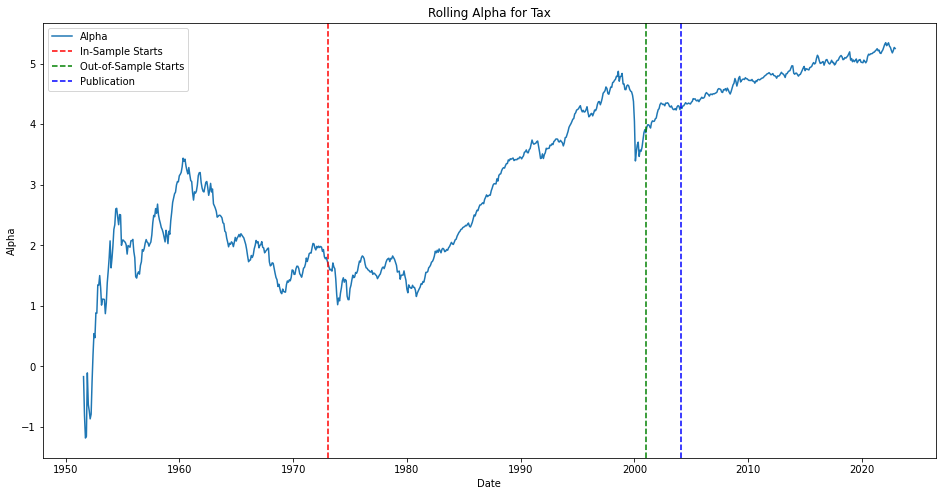

In [37]:
plot_rolling_alpha('Tax')

In [34]:
to_remove = ['ConvDebt', 'ExchSwitch', ]